---
title: "Notebook to explore DiffEdit"
author: "John Richmond"
format:
  html:
    code-fold: False
  pdf:
    geometry:
      - top=30mm
      - left=20mm
jupyter: python3
toc: true
number-sections: False
shift-heading-level-by: -1
---

### Notebook to try out the DiffEdit methodology

This follows the paper: http://arxiv.org/abs/2210.11427

The first part of the notebook is setup to generate image masks based upon the differences in images generated by starting with the same noised image and denoising it with two different prompts, the first one the prompt that goes with the image, the second a prompt related to a "target" image, which is what it is desired to change some aspect of the image into.

The methodology in the paper is not very well described and so a few alternative approaches are considered



In [1]:
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms as tfms
from torch import autocast

from diffusers import DDIMScheduler, LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import logging

In [2]:
#!pip install accelerate

In [3]:
# Note that this step is helpful to avoid verbose warnings when loading the text encoder
logging.set_verbosity_error()

In [4]:
# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# Load the tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to(torch_device)

In [6]:
# Load the VAE and Unet
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to(torch_device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(torch_device)

In [7]:
# Create a DDIM scheduler
ddim_sched = DDIMScheduler(beta_start=0.00085, 
                                    beta_end=0.012, 
                                    beta_schedule='scaled_linear', 
                                    clip_sample=False, 
                                    set_alpha_to_one=False)

In [8]:
# Create a LMS scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

### Add Functions

In [9]:
def prompt_to_embedding(prompt: str, torch_device):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    return embeddings

In [10]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).half().to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

In [11]:
def latents_to_array(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Create image array
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    # At this point, this is a single-item array of image data, so return only the item 
    # to remove the extra diemension from the returned data
    return images[0]

In [12]:
def latents_to_pil(latents):
    # bath of latents -> list of images
    image = latents_to_array(latents)
    pil_imagea = Image.fromarray(image)
    return pil_imagea

In [13]:
def show_latents(latents):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    for c in range(4):
        axs[c].imshow(latents[0][c].cpu(), cmap='Greys')
        axs[c].axis('off')

In [14]:
def load_image(path_to_image, size):
    path_to_img = Path(path_to_image)
    assert path_to_img.is_file(), f"No file found {path_to_image}"
    image = Image.open(path_to_img).convert('RGB')
    return image

In [15]:
def denoising_loop(latents, text_emb, scheduler, g=7.5, strength=0.5, steps=50, dim=512, start_step=10, torch_device="cuda"):
    with autocast(torch_device):
        noise_preds = torch.tensor([], device=torch_device)
        for i, t in enumerate(scheduler.timesteps):
            if i > start_step:
                #print(f"step: {i}")
                latent_model_input = torch.cat([latents] * 2)
                latent_model_input = scheduler.scale_model_input(latent_model_input, t)
                with torch.no_grad():
                    noise_u,noise_t = unet(latent_model_input, t, encoder_hidden_states=text_emb).sample.chunk(2)
                noise_pred = noise_u + g*(noise_t - noise_u)
                noise_preds = torch.concat([noise_preds, noise_pred])
                latents = scheduler.step(noise_pred, t, latents).prev_sample
        return latents, noise_preds

In [16]:
def show_image(image, seed=None, scale_by=0.5):
    if seed is not None:
        print(f'Seed: {seed}')
    return image.resize(((int)(image.width * scale_by), (int)(image.height * scale_by)))

In [17]:
def add_noise_to_image(latents, seed, scheduler, start_step):
    torch.manual_seed(seed)
    noise = torch.randn_like(latents)
    noised_latents = scheduler.add_noise(
        original_samples=latents, 
        noise=noise, 
        timesteps=torch.tensor([scheduler.timesteps[start_step]]))
    return noised_latents

In [18]:
def show_images(nrows, ncols, images, titles=[], figsize=(16, 5)):
    num_axes = nrows*ncols
    num_images = len(images)
    num_titles = len(titles)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    flt_ax = axs.flat
    for c in range(num_axes):
        if c == num_images: break
        flt_ax[c].imshow(images[c])
        flt_ax[c].axis('off')
        if c < num_titles:
            flt_ax[c].set_title(titles[c])

### Define parameters for analysis

In [19]:
resolution = 512
def_steps = 70
def_g = 7.5
def_strength = 0.5
def_sch = scheduler
start_step = 20

### Load base image and create latents

In [20]:
path_to_image = "/home/images/horse_1_512.jpg"
image = load_image(path_to_image, resolution)
latents = pil_to_latent(image)

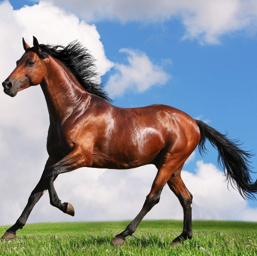

In [21]:
# show the base image
show_image(image)

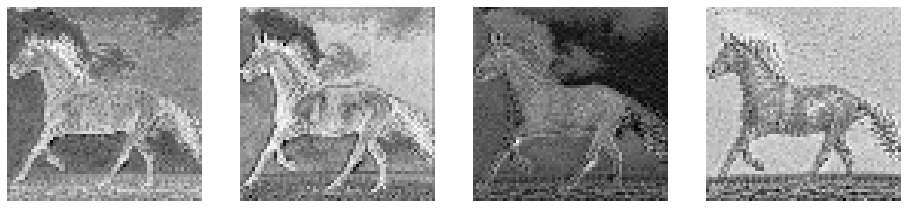

In [22]:
# Plot the latents
show_latents(latents)

### Define Prompts and create embeddings

In [23]:
#base_prompt = "A horse running on grass under a cloudy blue sky"
#target_prompt = "A zebra running on grass under a cloudy blue sky"
base_prompt = "A horse"
target_prompt = "Zebra"
unguided_prompt = [""]

In [24]:
base_prompt_emb = prompt_to_embedding(base_prompt, torch_device)
target_prompt_emb = prompt_to_embedding(target_prompt, torch_device)
unguided_prompt = prompt_to_embedding(unguided_prompt, torch_device)

In [25]:
base_emb_pair = torch.concat([unguided_prompt, base_prompt_emb])
target_emb_pair = torch.concat([unguided_prompt, target_prompt_emb])

### Set inference timesteps

In [26]:
def prepare_scheduler_noise_image_and_denoise(latents, text_emb, steps, start_step, scheduler, seed, g, dim, device):
    timesteps = scheduler.set_timesteps(steps)
    strength=0.5
    noised_latents = add_noise_to_image(latents, seed, scheduler, start_step)
    dn_latents, noise = denoising_loop(noised_latents, text_emb=text_emb, scheduler=scheduler, g=g, strength=strength, steps=70, 
                                           dim=dim, start_step=start_step, torch_device=device)
    return dn_latents, noise
    

In [27]:
dn_base, noise_base = prepare_scheduler_noise_image_and_denoise(latents, 
                                                                text_emb=base_emb_pair, 
                                                                steps=def_steps, 
                                                                start_step=30, 
                                                                scheduler=def_sch, 
                                                                seed=100, 
                                                                g=7.5,
                                                                dim=resolution, 
                                                                device=torch_device)

/opt/conda/lib/python3.8/site-packages/diffusers/schedulers/scheduling_lms_discrete.py:155: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrated_coeff = integrate.quad(lms_derivative, self.sigmas[t], self.sigmas[t + 1], epsrel=1e-4)[0]


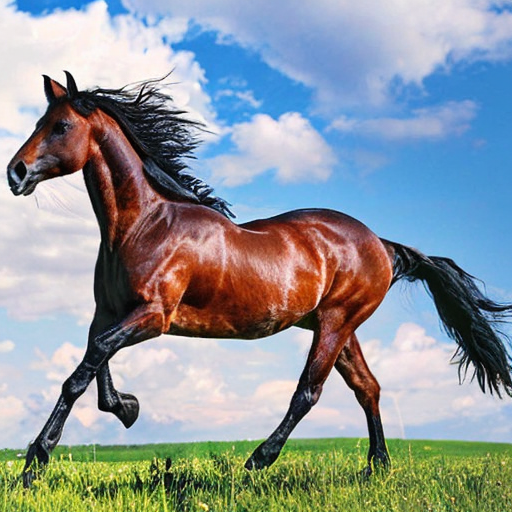

In [28]:
latents_to_pil(dn_base)

In [29]:
dn_target, noise_target = prepare_scheduler_noise_image_and_denoise(latents, 
                                                                text_emb=target_emb_pair, 
                                                                steps=def_steps, 
                                                                start_step=30, 
                                                                scheduler=def_sch, 
                                                                seed=100, 
                                                                g=7.5,
                                                                dim=resolution, 
                                                                device=torch_device)

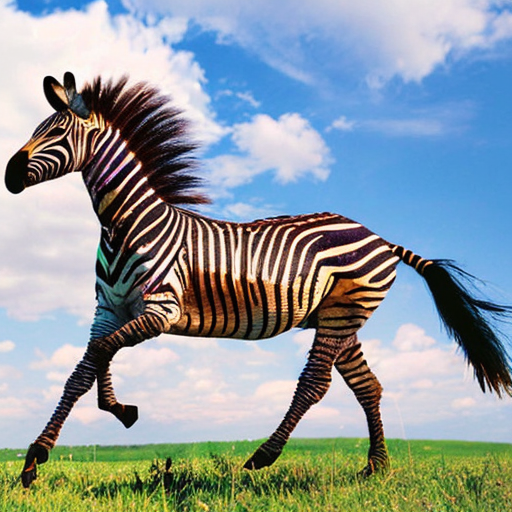

In [30]:
latents_to_pil(dn_target)

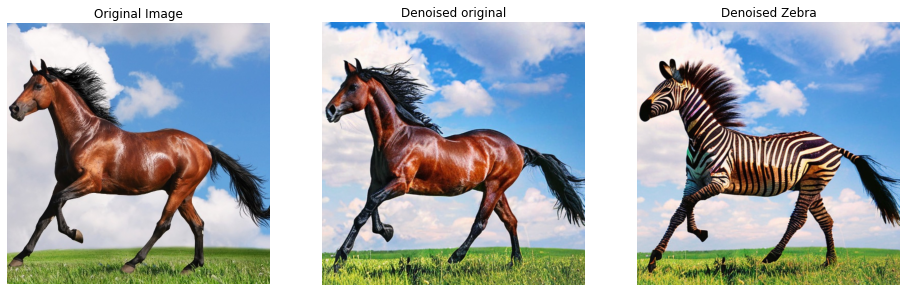

In [31]:
show_images(1, 3 , [np.asarray(image), latents_to_array(dn_base), latents_to_array(dn_target)],
           ["Original Image", "Denoised original", "Denoised Zebra", "Denoised Zebra with mask"])

In [32]:
orig_img = np.asarray(image)
orig_img.shape

(512, 515, 3)

In [33]:
noise_base.shape

torch.Size([39, 4, 64, 64])

In [34]:
diff_noises = (noise_base - noise_target).mean(0, keepdim=True)

In [35]:
diff_noises.shape

torch.Size([1, 4, 64, 64])

In [36]:
diff_noise_normed = (diff_noises - diff_noises.min())/(diff_noises - diff_noises.min()).max()

In [37]:
diff_noise_normed.shape

torch.Size([1, 4, 64, 64])

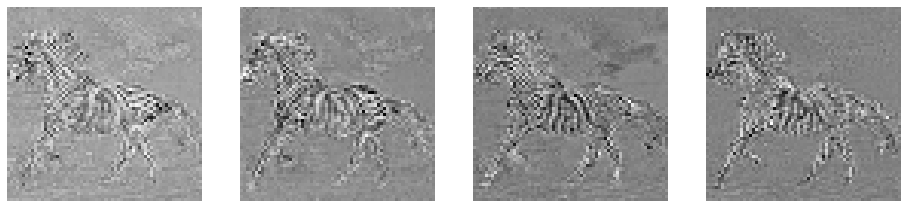

In [38]:
show_latents(diff_noise_normed)

In [39]:
diff_noise_normed.min(), diff_noise_normed.max(), diff_noise_normed.std(), diff_noise_normed.mean()

(tensor(0., device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(0.0744, device='cuda:0'),
 tensor(0.5083, device='cuda:0'))

In [40]:
mask = ((diff_noise_normed-0.5).abs()+0.5).mean(dim=1).squeeze().cpu()

In [41]:
import cv2

In [42]:
def extract_channel_mask(img, do_inverse=False):
    kernel = np.ones((3,3),np.uint8)
    img = (img*255).squeeze().cpu().to(torch.uint8).numpy()
    if do_inverse:
        ret2,img2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        ret2,img2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    opening = cv2.dilate(img2, kernel)
    return opening

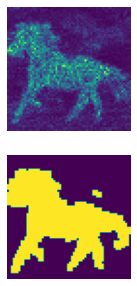

In [44]:
show_images(2, 1, [mask, extract_channel_mask(mask, do_inverse=False)])

###  Now need to apply the mask to the generated zebra image and then run the decode function 

In [45]:
binary_mask = torch.tensor(extract_channel_mask(mask, do_inverse=False)).bool()

In [46]:
def apply_mask_to_latents(original_latents, new_latents, mask):
    comp_lat = torch.where(mask, new_latents.cpu(), original_latents.cpu())
    return comp_lat

In [47]:
final_latents = apply_mask_to_latents(dn_base, dn_target, binary_mask)

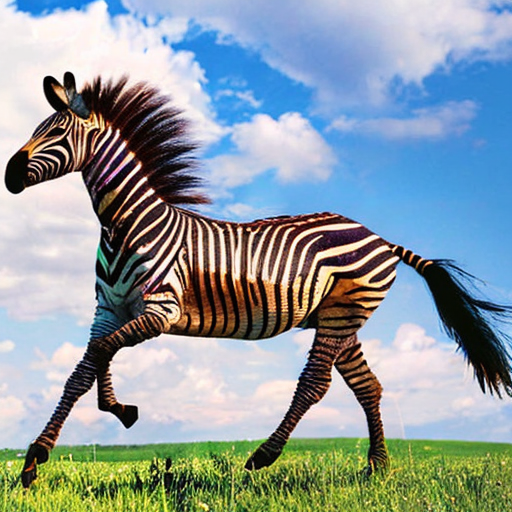

In [48]:
latents_to_pil(final_latents.to(torch_device))

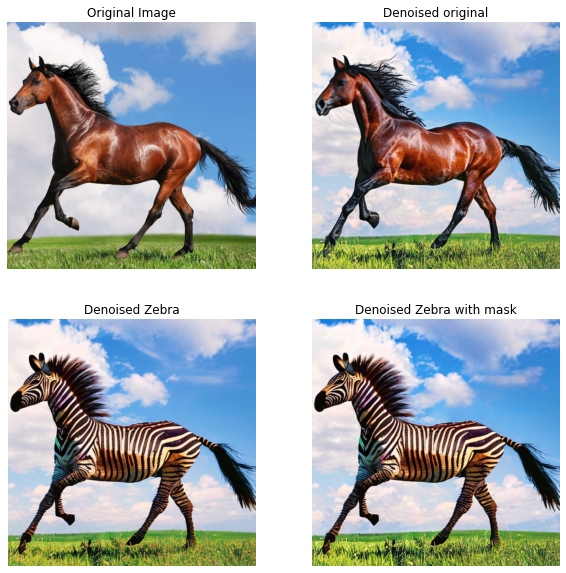

In [49]:
show_images(2, 2, [np.asarray(image), latents_to_array(dn_base), latents_to_array(dn_target), latents_to_array(final_latents.to(torch_device))],
           ["Original Image", "Denoised original", "Denoised Zebra", "Denoised Zebra with mask"], figsize=(10,10))

In this case the final masked image is almost identical to that of the unmasked image since the background generated by the denoising process had almost no differene.  In other cases this could clearly be more extreme.  The issue of course would be that the mask would need to be carefully blended to facilitate a smooth merge.

Overall it seems to me that this is an approach that has very limited application an in many ways it is better to avoid using the mask